# `bw_timex` Teaching Exercise - Time-explicit LCA of an Electric Vehicle vs Petrol Vehicle.

In this exercise notebook you will compare the climate preformance of a battery electric vehicle (BEV) and an internal combustion engine (ICE) car, in a time explicit way, using in different decarbonisation scenarios. 

Optional challenge at the end: 

- using temporal distributions, model the material requirements of a fleet of electric cars/busses.


In [1]:
# first we need to load the correct Brightway2 project with the required databases
import bw2data as bd

# project_name = "Timex_teaching"
project_name = "BAFU_report"

if project_name:# not in bd.projects:
    import bw2io as bi
    bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/SCENE/LCA model/databases/base_projects/brightway2-project-BAFU_report-backup07-November-2024-12-21PM.tar.gz',
                                    overwrite_existing=True)

bd.projects.set_current(project_name)

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


Restoring project backup archive - this could take a few minutes...
Restored project: BAFU_report


In [2]:
# check the databases present
print(bd.databases)

Databases dictionary with 6 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-07
	ei_cutoff_3.10_image_SSP2-Base_2030 2024-11-07
	ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-07
	ei_cutoff_3.10_image_SSP2-Base_2050 2024-11-07


## Prospective background databases

We used `premise` to create two different sets of 'ecoinvent-databases' representing two different carbonisation pathways. They are the based on the REMIND-EU IAM for the SSP2 scenario in combination with Paris Agreement consistent policies (PkBud650) as an (very) optimistic scenario, and the 'national policies implemented' (NPi) as a business as usual (BAU) scenario:

- REMIND-EU - SSP2-NPi       : BAU scenario with ~3˚ warming by 2100
- REMIND-EU - SSP2-PkBudg650 : Optimistic scenario in line with Paris 2015 with 1.5˚-1.9˚ warming bby 2100

(See [the Premise documentation](https://premise.readthedocs.io/en/latest/introduction.html#default-iam-scenarios) for a brief overview of the IAM scenarios) 



In [3]:
# Let's get easy handles for the databases for ease of use:

db_2020 = bd.Database("ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-07")
db_2030 = bd.Database("ei_cutoff_3.10_image_SSP2-Base_2030 2024-11-07")
db_2040 = bd.Database("ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-07")
db_2050 = bd.Database("ei_cutoff_3.10_image_SSP2-Base_2050 2024-11-07")


In [4]:
# db_2020_NPi = bd.Database("ei_cutoff_3.11_remind-eu_SSP2-NPi_2020 2025-10-01")
# db_2030_NPi = bd.Database("ei_cutoff_3.11_remind-eu_SSP2-NPi_2030 2025-10-01")
# db_2040_NPi = bd.Database("ei_cutoff_3.11_remind-eu_SSP2-NPi_2040 2025-10-01")
# db_2050_NPi = bd.Database("ei_cutoff_3.11_remind-eu_SSP2-NPi_2050 2025-10-01")

## Case study setup

In this exercise we will go about setting up the forground system in a slightly different way. In our case driving a(n electric) car is already represented in ecoinvent. So all we would need to do is to add the temporal distributions to the exchanges. In the current implementation of `bw_timex`, all activities 
containing temporal information on the exchanges need to 'live' in the foreground system, so that their inputs can get linked to different background activities.

Let's start the definition of our functional unit (FU): 

- Driving a passenger car for 200,000km (including production, EoL treatment, maintenance, etc), over a period of 15 years.


### Modeling the production system

As a first step of modelling the production system let's create a new foreground database:


In [5]:
fg_db_name = "foreground"

if fg_db_name in bd.databases:
    del bd.databases[fg_db_name] # to make sure we create the foreground from scratch
foreground = bd.Database(fg_db_name)
foreground.register()

And let's define the FU relevant quantities: 

In [6]:
LIFETIME_KM = 200000.  # lifetime of the vehicle in km
LIFETIME = 15  # lifetime of the vehicle in years
ANNUAL_KM = LIFETIME_KM / LIFETIME  # annual km

Now let's create two activities in the foreground that represent the functional units as defined above (production/driving/EoL treatment of a car for 200,000km over 15 years). We can call them LC_BEV and LC_ICEC for example (LC=life cyle)

In [7]:
LC_BEV = foreground.new_node("lc_bev", name="Life cycle of a BEV", unit="unit")
LC_BEV['reference product'] = "LC_BEV"
LC_BEV.save()

LC_ICEC = foreground.new_node("lc_icec", name="Life cycle of a internal combustion engine car")
LC_ICEC['reference product'] = "LC_ICEC"
LC_ICEC.save()


Ecoinvent already contains activities that represent transport with a passenger car. So let's get the following two activities from the base database** for the BAU scenario and create a copy in our foreground database:

- Driving a gasoline car: "transport, passenger car, gasoline, Medium SUV, EURO-6"
- Driving a BEV: "transport, passenger car, gasoline, Medium SUV, EURO-6"

HINT: copy to a different database by first copying the activity and then changing the database.

** We consider that as our base year and db_2020 as the 'base' database

In [8]:
# only run this cell once!
driving_icec = db_2020.get(name='transport, passenger car, gasoline, Medium SUV, EURO-6').copy()
driving_icec['database'] = fg_db_name
driving_bev = db_2020.get(name='transport, passenger car, battery electric, Medium SUV').copy()
driving_bev['database'] = fg_db_name

Successfully switch activity dataset to database `foreground`
Successfully switch activity dataset to database `foreground`


The Reference product of these activities should be 1 km traveled by the resepctive vehicle, but let's check the reference product and its unit:

In [9]:
print(f'Driving BEV reference product: {driving_bev.rp_exchange()}')
print(f'Driving BEV rp unit: {driving_bev.rp_exchange()["unit"]}')
print(f'Driving ICEC reference product: {driving_icec.rp_exchange()}')
print(f'Driving ICEC rp unit: {driving_icec.rp_exchange()["unit"]}')

Driving BEV reference product: Exchange: 1.0 kilometer 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>
Driving BEV rp unit: kilometer
Driving ICEC reference product: Exchange: 1.0 kilometer 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>
Driving ICEC rp unit: kilometer


Have a look at what the inputs into such a car is and identify the relevant exchanges:

In [10]:
[exc for exc in driving_bev.technosphere()]

[Exchange: 1.003274597657886e-05 unit 'maintenance, passenger car' (unit, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: -8.875492874499866e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 6.330434782608695e-06 kilogram 'market for refrigerant R134a' (kilogram, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 0.00107727073363265 meter-year 'market for road' (meter-year, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 0.00129 meter-year 'market for road maintenance' (meter-year, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: -1.896191731771129e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None) 

In [11]:
[exc for exc in driving_icec.technosphere()]

[Exchange: 7.640378645840602e-06 unit 'maintenance, passenger car' (unit, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.427136857274651e-05 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 6.330434782608695e-06 kilogram 'market for refrigerant R134a' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.000838316299903851 meter-year 'market for road' (meter-year, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.00129 meter-year 'market for road maintenance' (meter-year, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.572326934208801e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None)

These activities include both the car, which in itself contains both production and EoL treatment (check this!!), as well as the fuel/electricity, maintenance and wear etc. Now we want to model the production and EoL treatment of car and it's elements separately so let's make a copy of these activities in the foreground so that we can add temporal distributions to the production and EoL.

At the same time we want to split the driving and production/EoL so set the input of the car into the driving activity to 0 to avoid double counting.

In [12]:
# first copy the activities production/EoL treatment of the cars into the foreground
bev_production_eol = db_2020.get(name='passenger car, battery electric, Medium SUV').copy()
bev_production_eol['database'] = fg_db_name

icec_production_eol = db_2020.get(name='Passenger car, gasoline, Medium SUV, EURO-6d').copy()
icec_production_eol['database'] = fg_db_name


Successfully switch activity dataset to database `foreground`
Successfully switch activity dataset to database `foreground`


In [13]:
# now set the input of the car into the driving activity to 0 to avoid double counting
for exc in driving_bev.technosphere():
    if exc.input['name'] == 'passenger car, battery electric, Medium SUV':
        exc.delete()
        break
for exc in driving_icec.technosphere():
    if exc.input['name'] == 'Passenger car, gasoline, Medium SUV, EURO-6d':
        exc.delete()
        break

Now it is time to add the relevant exchanges to the functional unit activities together with relevant temporal distributions. Be carefull to add the temporal distribution to poduction and EoL at the right exchnage, so that production happens before the use phase but EoL after the use phase. 

Tipp: for ease of use, or if you forgot how to define temporal distributions you can use the interactive_td_widget!

Tipp 2: Use the utility function add_temporal_distribution_to_exchange to add the temporal distribution to the EoL of the production/EoL activity of the cars. 


In [14]:
# from bw_timex.utils import interactive_td_widget
from bw_timex.utils import add_temporal_distribution_to_exchange
from bw_temporalis import easy_timedelta_distribution

In [15]:
# interactive_td_widget()

In [16]:
LC_BEV.new_edge(input=LC_BEV, amount=1, type='production').save()
LC_BEV.new_edge(input=driving_bev, amount=LIFETIME_KM, type='technosphere').save()
LC_BEV.new_edge(input=bev_production_eol, amount=1, type='technosphere').save()

LC_ICEC.new_edge(input=LC_ICEC, amount=1, type='production').save()
LC_ICEC.new_edge(input=driving_icec, amount=LIFETIME_KM, type='technosphere').save()
LC_ICEC.new_edge(input=icec_production_eol, amount=1, type='technosphere').save()

In [17]:
# now define and add the temporal distributions to the relevant exchanges
# for the production of the cars, we assume a uniform distribution over 5 years prior to use
# for the use phase, we assume a uniform distribution over the lifetime of the car (15 years)
# for the EoL, a fixed point in time at the end of the lifetime + 1 year

td_driving =  easy_timedelta_distribution(
    start=0,
    end=15,
    resolution='Y',
    steps=16,
    kind='uniform'
)

td_production = easy_timedelta_distribution(
    start=-5,
    end=-1,
    resolution='Y',
    steps=6,
    kind='uniform'
)

import numpy as np
from bw_temporalis import TemporalDistribution

date = np.array([16], dtype='timedelta64[Y]')
amount = np.array([1], dtype=float)
td_eol = TemporalDistribution(date=date, amount=amount)


add_temporal_distribution_to_exchange(td_driving,
                                      input_node=driving_bev,
                                      output_node=LC_BEV
                                      )
add_temporal_distribution_to_exchange(td_driving,
                                      input_node=driving_icec,
                                      output_node=LC_ICEC
                                      )

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/bw_temporalis/utils.py:194: UserWarning: More steps than discrete possibilities (6 versus 5).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)


In [18]:
# Now we add the temporal distributions for production and end of life to the exchanges of the 
# production/EoL activities of the cars. Here we will make use of the fact that in ecoinvent waste treatment
# activities are modelled as negative inputs. 

for exc in bev_production_eol.technosphere():
    if exc['amount'] >= 0:  # production
        add_temporal_distribution_to_exchange(td_production,
                                              input_node=exc.input,
                                              output_node=exc.output)
    else:  # EoL
        add_temporal_distribution_to_exchange(td_eol,
                                              input_node=exc.input,
                                              output_node=exc.output)
for exc in icec_production_eol.technosphere():
    if exc['amount'] >= 0:  # production
        add_temporal_distribution_to_exchange(td_production,
                                              input_node=exc.input,
                                              output_node=exc.output)
    else:  # EoL
        add_temporal_distribution_to_exchange(td_eol,
                                              input_node=exc.input,
                                              output_node=exc.output)

### Checking all went right

Now before calculating the time-explicit LCA, make sure that everything went right so far. As a check, the standard LCA score of the original transport activity with the corresponding amount should be equal the standard LCA of the modified life cycle activity created in the foreground!

In [19]:
for method in bd.methods:
    if 'climate change' in method:
        print(method)

('ecoinvent-3.10', 'CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
('ecoinvent-3.10', 'Ecological Scarcity 2021', 'climate change', 'global warming potential (GWP100)')
('ecoinvent-3.10', 'EF v3.0', 'climate change', 'global warming potential (GWP100)')
('ecoinvent-3.10', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')
('ecoinvent-3.10', 'IMPACT World+ v2.0.1, footprint version', 'climate change', 'carbon footprint')
('ecoinvent-3.10', 'IPCC 2013', 'climate change', 'global temperature change potential (GTP100)')
('ecoinvent-3.10', 'IPCC 2013', 'climate change', 'global temperature change potential (GTP20)')
('ecoinvent-3.10', 'IPCC 2013', 'climate change', 'global warming potential (GWP100)')
('ecoinvent-3.10', 'IPCC 2013', 'climate change', 'global warming potential (GWP20)')
('ecoinvent-3.10', 'IPCC 2021', 'climate change', 'global temperature change potential (GTP100)')
('ecoinvent-3.10', 'IPCC 2021', 'climate change', 'global temperature c

In [20]:
import bw2calc as bc

# standard LCA of the original transport activity with the corresponding amount
transport_icec = db_2020.get(name='transport, passenger car, gasoline, Medium SUV, EURO-6')
method = ('ecoinvent-3.10', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')
lca = bc.LCA({transport_icec: LIFETIME_KM}, method)
lca.lci()
lca.lcia()
print(f'Life cycle impact score: {lca.score} kg CO2-eq for {LIFETIME_KM} km driving with ICEC')

# standard LCA of the modified life cycle activity created in the foreground
lca_fg = bc.LCA({LC_ICEC: 1}, method)
lca_fg.lci()
lca_fg.lcia()
print(f'Life cycle impact score: {lca_fg.score} kg CO2-eq for {LIFETIME_KM} km driving with ICEC')

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Life cycle impact score: 66786.77290576225 kg CO2-eq for 200000.0 km driving with ICEC
Life cycle impact score: 66786.77317649123 kg CO2-eq for 200000.0 km driving with ICEC


In [21]:
# now the same for the BEV
# standard LCA of the original transport activity with the corresponding amount
transport_bev = db_2020.get(name='transport, passenger car, battery electric, Medium SUV')
lca_bev = bc.LCA({transport_bev: LIFETIME_KM}, method)
lca_bev.lci()
lca_bev.lcia()
print(f'Life cycle impact score: {lca_bev.score} kg CO2-eq for {LIFETIME_KM} km driving with BEV')  

# standard LCA of the modified life cycle activity created in the foreground
lca_bev_fg = bc.LCA({LC_BEV: 1}, method)
lca_bev_fg.lci()
lca_bev_fg.lcia()
print(f'Life cycle impact score: {lca_bev_fg.score} kg CO2-eq for {LIFETIME_KM} km driving with BEV')

Life cycle impact score: 41335.40820351815 kg CO2-eq for 200000.0 km driving with BEV
Life cycle impact score: 41335.40864914075 kg CO2-eq for 200000.0 km driving with BEV


## Time-explicit LCA with `bw_timex`

Now we can start using `bw_timex` to build the process timeline, build the time-explicit inventory and calculate the time explicit scores.

Start by creating a dictionary mapping the respective databases to the relevant timestamps. 
Then instantiate your timexLCA object, build the timeline, calculate the lci, and the LCIA for both options.


In [22]:
from datetime import datetime

database_dates = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    db_2030.name: datetime.strptime("2030", "%Y"),
    db_2040.name: datetime.strptime("2040", "%Y"),
    db_2050.name: datetime.strptime("2050", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}

In [23]:
from bw_timex import TimexLCA

In [42]:
tlca_BEV = TimexLCA({LC_BEV: 1}, method, database_dates)
tlca_BEV.build_timeline(temporal_grouping="year")  # build timeline with yearly steps

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)
2025-10-07 20:59:12.920 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 21


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2021-01-01,"market for glider, passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",233.333333,{'ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-...
1,2021-01-01,"market for power distribution unit, for electr...",2026-01-01,"passenger car, battery electric, Medium SUV",0.662319,{'ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-...
2,2021-01-01,"market for inverter, for electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",1.490217,{'ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-...
3,2021-01-01,"market for charger, electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",0.993478,{'ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-...
4,2021-01-01,"market for converter, for electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",0.745109,{'ei_cutoff_3.10_image_SSP2-Base_2020 2024-11-...
...,...,...,...,...,...,...
146,2041-01-01,market for road,2041-01-01,"transport, passenger car, battery electric, Me...",0.001077,{'ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-...
147,2041-01-01,"market group for electricity, low voltage",2041-01-01,"transport, passenger car, battery electric, Me...",0.262637,{'ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-...
148,2042-01-01,"treatment of used internal combustion engine, ...",2026-01-01,"passenger car, battery electric, Medium SUV",-89.417404,{'ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-...
149,2042-01-01,market for used powertrain from electric passe...,2026-01-01,"passenger car, battery electric, Medium SUV",-112.672485,{'ei_cutoff_3.10_image_SSP2-Base_2040 2024-11-...


In [ ]:
tlca_BEV.lci()  # calculate the dynamic inventory
tlca_BEV.dynamic_lcia(metric="GWP", fixed_time_horizon=True)  # calculate the dynamic LCIA for GWP100

2025-10-07 20:55:34.401 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


,date,amount,flow,activity
0,2021-01-01,-18.284435,1034,167140
1,2021-01-01,-0.085899,1392,167140
2,2021-01-01,-0.008224,3269,167132
3,2021-01-01,-0.005098,4194,167140
4,2021-01-01,-0.003143,1369,167140
...,...,...,...,...
11050,2042-01-01,8.436186,4192,167282
11051,2042-01-01,23.349415,1390,167282
11052,2042-01-01,31.487699,107,167280
11053,2042-01-01,71.300076,1031,167282


In [64]:
tlca_BEV.dynamic_score

33196.52307420372

In [59]:
tlca_ICEC = TimexLCA({LC_ICEC: 1}, method, database_dates)
tlca_ICEC.build_timeline(temporal_grouping="year")  # build timeline with yearly steps
tlca_ICEC.lci()  # calculate the dynamic inventory
tlca_ICEC.dynamic_lcia(metric="GWP", fixed_time_horizon=True)

2025-10-07 21:15:12.910 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 15


/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.70e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.70e+12)
  warnings.warn(msg, UmfpackWarning)
2025-10-07 21:15:52.914 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


,date,amount,flow,activity
0,2021-01-01,-11.924632,1034,167135
1,2021-01-01,-0.056021,1392,167135
2,2021-01-01,-0.007050,3269,167132
3,2021-01-01,-0.003325,4194,167135
4,2021-01-01,-0.002050,1369,167135
...,...,...,...,...
8733,2042-01-01,13.438397,1031,167250
8734,2042-01-01,21.739354,1390,167251
8735,2042-01-01,66.383570,1031,167251
8736,2042-01-01,86.232860,107,167250


In [60]:
tlca_ICEC.dynamic_score

63554.55699311766

## Visualise Results and compare the different cars and scenarios

now find a good way to visualise the results. There are some simple plotting functions included such as plot_dynamic_inventory().

Run the other scenario to see the differences for both cars. 

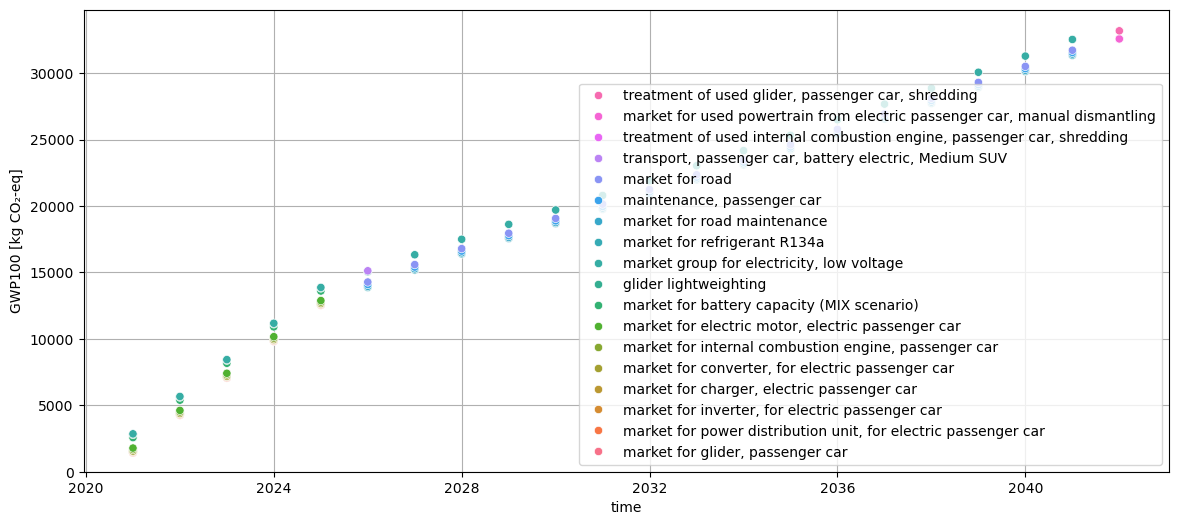

In [65]:
tlca_BEV.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

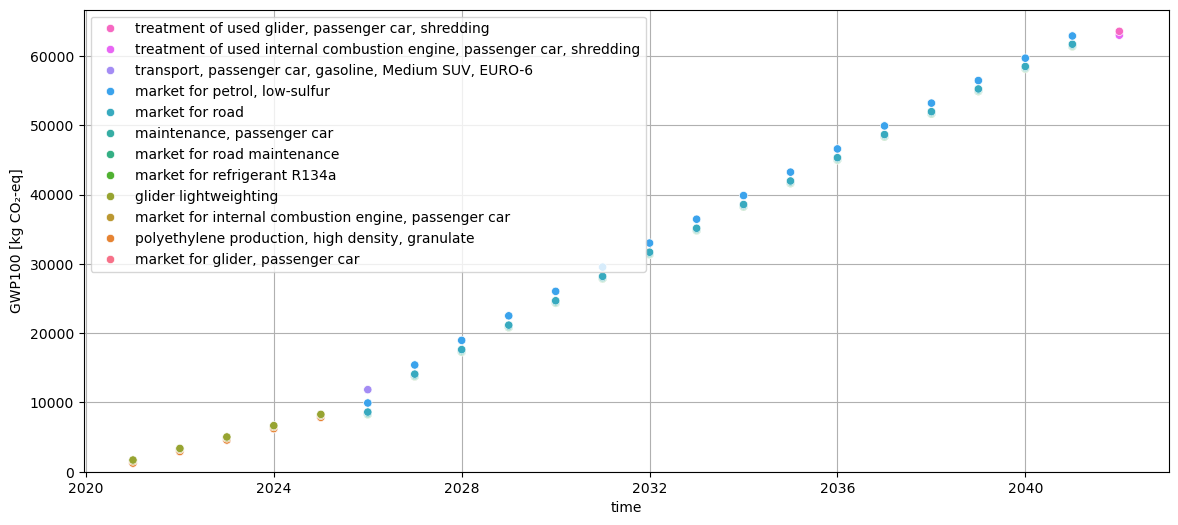

In [62]:
tlca_ICEC.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

## BONUS options:

- Use dynamic_lcia(use_disaggregated_lci=TRUE) to perform a contribution analysis on the background activities contributing to the impacts. (Note that this function can take a while), find a good way to visualize thi

- Adavanced: Use temporal distritbutions to modell a fleet (of changing composition). (hint a for a fleet some cars will live longer, some shorter. This can be modelled using a distribution for the usephase and the EoL)



